## 2.4　カウントベースの手法の改善

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.chdir('/Users/yuta.shimizu/Downloads/ML/deep-learning-from-scratch-2-master/ch02')
sys.path.append(os.pardir)

In [3]:
from common.util import preprocess, create_co_matrix, cos_similarity, most_similar
from dataset import ptb

### 2.4.1　相互情報量

In [4]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
                    
    return M

`S[i]` と `S[j]` は、$C(x)$ と $C(y)$ に対応している。

In [5]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

In [6]:
np.set_printoptions(precision=3)
print('covariance matrix')
print(C)
print(' - ' * 50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [7]:
N = np.sum(C)
S = np.sum(C, axis=0)
total = C.shape[0] * C.shape[1]
print(N)
print(S)
print(total)

14
[1 4 2 2 2 2 1]
49


### 2.4.3　SVD による次元削減

In [8]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)
U, S, V = np.linalg.svd(W)

In [9]:
print(C[0])
print(W[0])
print(U[0])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01  0.000e+00 -3.886e-16 -1.205e-01 -9.323e-01 -1.110e-16
  1.958e-17]


In [10]:
print(U[0, :2])

[0.341 0.   ]


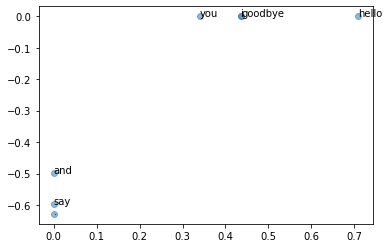

In [11]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

### 2.4.4　PTB データセット

In [12]:
corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size: ', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()

print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

corpus size:  929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0] aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


### 2.4.5　PTB データセットでの評価

In [13]:
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
    
except ImportError:
    U, S, V = np.linalg.svd(W)
    
word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting co-occurrence ...
calculating PPMI ...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0